In [1]:
# implementacao e treinamento da rede
import torch
from torch import nn, optim

# dados
from torch.utils.data import DataLoader, Dataset
# from torchvision import models, transforms
from backtesting import *
# plots
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, precision_recall_fscore_support

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
args = {
    'epoch_num': 5,
    'lr': 1e-4,
    'num_workes': 10,  # numero de processos
    'weight_decay': 8e-4,
    'batch_size': 20
}

In [3]:
# Configurando Hardware
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


# Carregando base

In [4]:
class HistoricoAcoes(Dataset):
    # , scaler_feat=None, sacaler_label=None):
    def __init__(self, path_x, path_y):
        self.X = np.load(path_x).astype('float32')
        if '.npy' in path_y:
            self.y = np.load(path_y).reshape(-1, 1).astype('int64')
        else:
            self.y = path_y

    def __getitem__(self, index):
        sample = torch.from_numpy(self.X[index])
        label = torch.from_numpy(self.y[index])

        return sample, label

    def __len__(self):
        return self.X.shape[0]

In [5]:
path_train_x = 'base/X_train_balance_torch_1.npy'
path_train_y = 'base/y_train_balance_torch_1.npy'
path_test_x = 'base/X_test_torch_1.npy'
path_test_y = 'base/y_test_torch_1.npy'

In [6]:
train_set = HistoricoAcoes(path_x=path_train_x, path_y=path_train_y)
test_set = HistoricoAcoes(path_x=path_test_x, path_y=path_test_y)

In [7]:
dado, label = train_set[0]

In [8]:
dado, label = test_set[0]

## construindo DataLoader

In [9]:
train_loader = DataLoader(
    train_set,
    batch_size=args['batch_size'],
    shuffle=True
)

In [10]:
test_loader = DataLoader(
    test_set,
    batch_size=args['batch_size'],
    shuffle=True
)

In [11]:
# exenoki

# Construindo Rede

In [12]:
# reference Sezer (2018) "Algorithmic financial trading with deep convolutional neural networks: Time series to image conversion approach"

class CNN_signal(nn.Module):
    # camada convulocional 1
    def __init__(self):
        super(CNN_signal, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # camada convulocional 2
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # camada de pooling máxima
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # camada dropout 1
        self.dropout1 = nn.Dropout(0.25)
        # camada dropout 2
        self.dropout2 = nn.Dropout(0.5)
        # camda totalmente conectada 1
        self.fc1 = nn.Linear(64*14*14, 128)
        # camada de saida
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        # Passando pela primeira camada convolucional e pela função de ativação ReLU
        x = nn.functional.relu(self.conv1(x))
        # Passando pela segunda camada convolucional e pela função de ativação ReLU
        x = nn.functional.relu(self.conv2(x))
        # Aplicando pooling máxima
        x = self.pool(x)
        # Aplicando dropout
        x = self.dropout1(x)
        # Achatar o tensor para a camada totalmente conectada
        x = x.view(-1, 64*14*14)
        # Primeira camada totalmente conectada
        x = nn.functional.relu(self.fc1(x))
        # Aplicando dropout
        x = self.dropout2(x)
        # Camada de saída
        x = self.fc2(x)
        return x

In [13]:
# criando rede
net = CNN_signal()

# Criterion

In [14]:
# funcao de perda
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.Adam(
    net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

# Treino

In [15]:
import time
import os


def train(train_loader, net, epoch):

    # Training mode
    net.train()

    start = time.time()

    epoch_loss = []
    pred_list, rotulo_list = np.array([]), np.array([])
    for batch in tqdm(train_loader):

        dado, rotulo = batch
        dado = dado.view(dado.size(0), 1, dado.size(1), dado.size(2))
        rotulo = rotulo.view(-1)
        # Cast do dado na GPU
        dado = dado.to(args['device'], dtype=torch.float32)
        rotulo = rotulo.to(args['device'], dtype=torch.long)

        # Forward
        ypred = net(dado)
        loss = criterion(ypred, rotulo)
        epoch_loss.append(loss.cpu().data)

        _, pred = torch.max(ypred, axis=1)
        # pred_list.append(pred.cpu().numpy())
        # rotulo_list.append(rotulo.cpu().numpy())
        pred_list = np.append(pred.cpu().numpy(), pred_list)
        rotulo_list = np.append(rotulo.cpu().numpy(), rotulo_list)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = np.array(epoch_loss)
    pred_list = np.array(pred_list).ravel()
    rotulo_list = np.array(rotulo_list).ravel()

    acc = accuracy_score(pred_list, rotulo_list)
    precision_recall = precision_recall_fscore_support(pred_list, rotulo_list)

    end = time.time()
    print('#################### Train ####################')
    print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Prec 2: %.2f ,Prec 3: %.2f ,Time: %.2f' %
          (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, precision_recall[0][1]*100, precision_recall[0][2]*100, end-start))

    return epoch_loss.mean()

In [16]:
def validate(test_loader, net, epoch):

    # Evaluation mode
    net.eval()

    start = time.time()

    epoch_loss = []
    pred_list, rotulo_list = np.array([]), np.array([])
    # with torch.no_grad():
    for batch in tqdm(test_loader):

        dado, rotulo = batch

        # Cast do dado na GPU
        dado = dado.view(dado.size(0), 1, dado.size(1), dado.size(2))
        rotulo = rotulo.view(-1)

        dado = dado.to(args['device'], dtype=torch.float32)
        rotulo = rotulo.to(args['device'], dtype=torch.long)
        rotulo[rotulo < 0] = 0

        num_classes = 3  # Supondo que haja 3 classes
        if rotulo.max().item() >= num_classes or rotulo.min().item() < 0:
            print(f"Os rótulos estão fora do intervalo esperado.\n min: {
                  rotulo.min().item()}\n max: {rotulo.max().item()}")
            # raise ValueError("Os rótulos estão fora do intervalo esperado.")

        else:
            # Forward
            ypred = net(dado)
            loss = criterion(ypred, rotulo.view(-1))
            epoch_loss.append(loss.cpu().data)

            _, pred = torch.max(ypred, axis=1)
            # pred_list.append(pred.cpu().numpy())
            # rotulo_list.append(rotulo.cpu().numpy())
            pred_list = np.append(pred.cpu().numpy(), pred_list)
            rotulo_list = np.append(rotulo.cpu().numpy(), rotulo_list)

    epoch_loss = np.asarray(epoch_loss)
    pred_list = np.asarray(pred_list).ravel()
    rotulo_list = np.asarray(rotulo_list).ravel()

    acc = accuracy_score(pred_list, rotulo_list)
    precision_recall = precision_recall_fscore_support(pred_list, rotulo_list)

    end = time.time()
    print('********** Validate **********')
    # print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f\n' %
    #       (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))
    print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Prec 2: %.2f ,Prec 3: %.2f ,Time: %.2f' %
          (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, precision_recall[0][1]*100, precision_recall[0][2]*100, end-start))

    return epoch_loss.mean()

In [17]:
net.to(args['device'])

CNN_signal(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [18]:
train_loss = []
test_loss = []
epoch_train = 0
epoch_test = 0
# treinamento
for epoch in range(10):  # 36 min 50
    if abs(epoch_train-epoch_test) <= 0.4:
        epoch_train = train(train_loader=train_loader, net=net, epoch=epoch)
        train_loss.append(epoch_train)
        # Validat
        epoch_test = validate(test_loader, net, epoch)
        test_loss.append(epoch_test)

    else:
        break

100%|██████████| 11526/11526 [01:13<00:00, 157.29it/s]


#################### Train ####################
Epoch 0, Loss: 0.8137 +/- 0.1307, Acc: 60.98, Prec 2: 80.80 ,Prec 3: 77.38 ,Time: 73.42


100%|██████████| 267/267 [00:00<00:00, 493.59it/s]


********** Validate **********
Epoch 0, Loss: 0.9366 +/- 0.1050, Acc: 40.28, Prec 2: 75.00 ,Prec 3: 76.20 ,Time: 0.55


100%|██████████| 11526/11526 [01:11<00:00, 161.57it/s]


#################### Train ####################
Epoch 1, Loss: 0.6691 +/- 0.1261, Acc: 69.68, Prec 2: 85.17 ,Prec 3: 83.63 ,Time: 71.56


100%|██████████| 267/267 [00:00<00:00, 503.23it/s]


********** Validate **********
Epoch 1, Loss: 0.8545 +/- 0.1294, Acc: 48.86, Prec 2: 64.77 ,Prec 3: 71.10 ,Time: 0.54


100%|██████████| 11526/11526 [01:10<00:00, 163.10it/s]


#################### Train ####################
Epoch 2, Loss: 0.5704 +/- 0.1240, Acc: 74.91, Prec 2: 88.90 ,Prec 3: 87.54 ,Time: 70.81


100%|██████████| 267/267 [00:00<00:00, 496.68it/s]


********** Validate **********
Epoch 2, Loss: 0.7809 +/- 0.1603, Acc: 55.23, Prec 2: 61.65 ,Prec 3: 53.54 ,Time: 0.54


100%|██████████| 11526/11526 [01:10<00:00, 162.80it/s]


#################### Train ####################
Epoch 3, Loss: 0.4958 +/- 0.1214, Acc: 78.77, Prec 2: 91.02 ,Prec 3: 90.12 ,Time: 70.94


100%|██████████| 267/267 [00:00<00:00, 473.65it/s]


********** Validate **********
Epoch 3, Loss: 0.7682 +/- 0.2034, Acc: 59.08, Prec 2: 56.53 ,Prec 3: 52.69 ,Time: 0.57


100%|██████████| 11526/11526 [01:09<00:00, 166.73it/s]


#################### Train ####################
Epoch 4, Loss: 0.4379 +/- 0.1210, Acc: 81.53, Prec 2: 92.15 ,Prec 3: 91.50 ,Time: 69.27


100%|██████████| 267/267 [00:00<00:00, 503.50it/s]


********** Validate **********
Epoch 4, Loss: 0.7125 +/- 0.2111, Acc: 61.91, Prec 2: 48.01 ,Prec 3: 45.04 ,Time: 0.54


100%|██████████| 11526/11526 [01:08<00:00, 167.73it/s]


#################### Train ####################
Epoch 5, Loss: 0.3952 +/- 0.1217, Acc: 83.59, Prec 2: 92.98 ,Prec 3: 92.33 ,Time: 68.86


100%|██████████| 267/267 [00:00<00:00, 494.55it/s]


********** Validate **********
Epoch 5, Loss: 0.6772 +/- 0.2379, Acc: 67.54, Prec 2: 43.18 ,Prec 3: 35.69 ,Time: 0.55


100%|██████████| 11526/11526 [01:11<00:00, 160.44it/s]


#################### Train ####################
Epoch 6, Loss: 0.3646 +/- 0.1206, Acc: 85.06, Prec 2: 93.48 ,Prec 3: 93.03 ,Time: 72.07


100%|██████████| 267/267 [00:00<00:00, 508.56it/s]


********** Validate **********
Epoch 6, Loss: 0.6455 +/- 0.2329, Acc: 70.23, Prec 2: 33.81 ,Prec 3: 30.88 ,Time: 0.53


100%|██████████| 11526/11526 [01:10<00:00, 163.15it/s]


#################### Train ####################
Epoch 7, Loss: 0.3426 +/- 0.1191, Acc: 86.13, Prec 2: 93.90 ,Prec 3: 93.38 ,Time: 70.79


100%|██████████| 267/267 [00:00<00:00, 510.24it/s]


********** Validate **********
Epoch 7, Loss: 0.6265 +/- 0.2550, Acc: 72.70, Prec 2: 26.14 ,Prec 3: 29.46 ,Time: 0.53


100%|██████████| 11526/11526 [01:10<00:00, 162.51it/s]


#################### Train ####################
Epoch 8, Loss: 0.3221 +/- 0.1194, Acc: 87.00, Prec 2: 94.16 ,Prec 3: 93.83 ,Time: 71.06


100%|██████████| 267/267 [00:00<00:00, 618.36it/s]


********** Validate **********
Epoch 8, Loss: 0.6623 +/- 0.2601, Acc: 70.19, Prec 2: 31.53 ,Prec 3: 29.46 ,Time: 0.44


100%|██████████| 11526/11526 [01:09<00:00, 166.26it/s]


#################### Train ####################
Epoch 9, Loss: 0.3080 +/- 0.1172, Acc: 87.56, Prec 2: 94.41 ,Prec 3: 93.88 ,Time: 69.47


100%|██████████| 267/267 [00:00<00:00, 466.75it/s]


********** Validate **********
Epoch 9, Loss: 0.6488 +/- 0.2829, Acc: 73.10, Prec 2: 24.72 ,Prec 3: 30.88 ,Time: 0.58


## Convergência

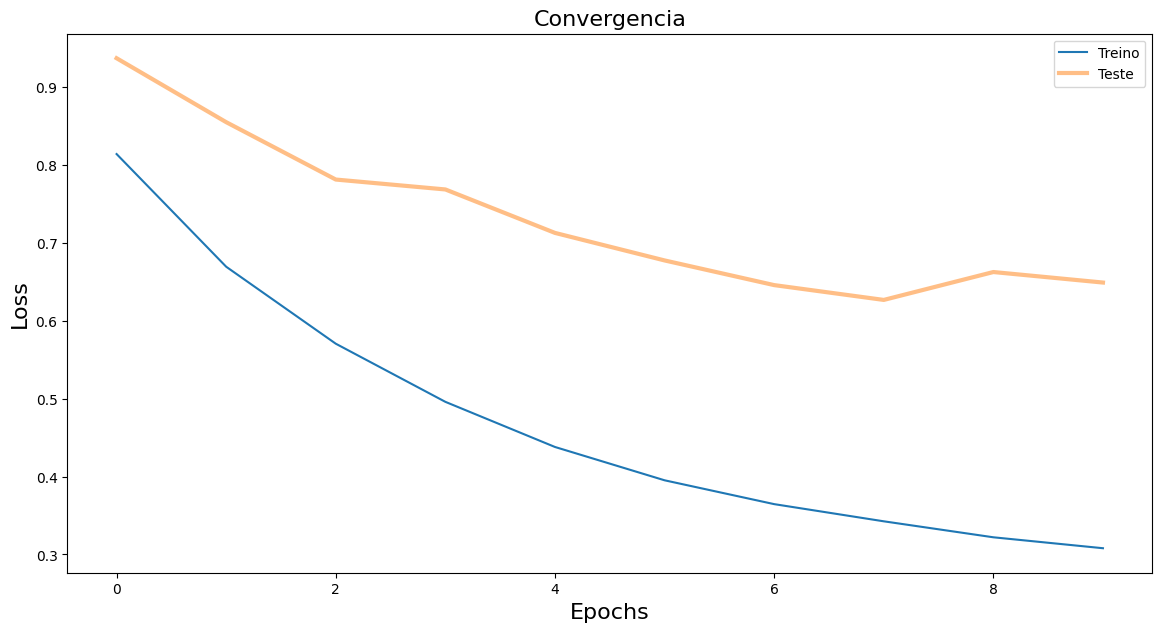

In [19]:
plt.figure(figsize=(14, 7))
plt.plot(train_loss, label='Treino')
plt.plot(test_loss, label='Teste', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergencia', fontsize=16)
plt.legend()
plt.show()

In [39]:
# salvando modelo
torch.save(net.state_dict(), 'base/model_1_10_epoch')

# Teste

In [20]:
df_test = pd.read_csv('base/y_test.csv')

In [21]:
X_test = torch.from_numpy(test_set.X.astype('float32'))
X_test = X_test.view(X_test.size(0), 1, X_test.size(1), X_test.size(2))

In [22]:
net.to('cpu')
y_pred = net(X_test)
score, pred = torch.max(y_pred, axis=1)
y_pred = pred.cpu().numpy()
score = score.detach().cpu().numpy()

y_test = test_set.y.astype('int')

In [23]:
y_test.shape

(5330, 1)

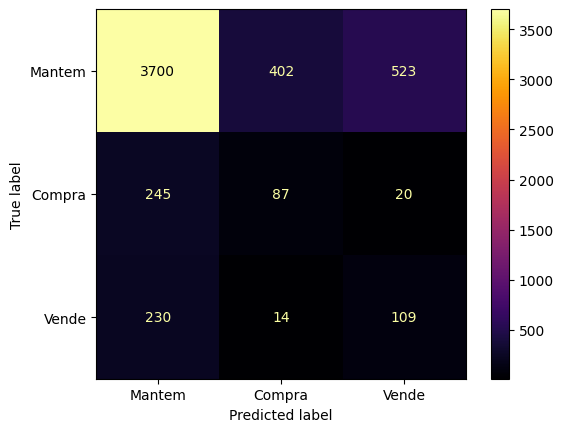

In [24]:
cross = pd.crosstab(y_test.flatten(), y_pred)

matrix = cross.values
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=matrix, display_labels=["Mantem", "Compra", "Vende"])

# display matrix
cm_display.plot(cmap='inferno')

In [25]:
precision, recall, fscore, support = precision_recall_fscore_support(
    y_pred=y_pred,
    y_true=y_test
)

In [26]:
resultado_best = pd.DataFrame(
    {
        'precision': precision,
        'recall': recall,
        'f1score': fscore
    },
    index=['manter', 'comprar', 'vender']
)
resultado_best

,precision,recall,f1score
manter,0.886228,0.800000,0.840909
comprar,0.172962,0.247159,0.203509
vender,0.167178,0.308782,0.216915


# Backtesting

In [27]:
def test_modelos(acao, df_val=None):
    signais = [i for i in df_val.columns if 'signal' in i]
    df_aux = df_val.loc[
        df_val['acao'] == acao,
        ['Date', 'Close']+signais
    ]

    performances = []

    for sinal in signais:
        bkt_l1 = Backtesting(
            df=df_aux,
            sinal=sinal,
            capital_inicial=1000
        )
        bkt_l1.backtesting()
        performance = round(bkt_l1.capital, 1)
        performances.append(performance)
    return performances, signais

In [28]:
# sinal previsto
df_test['signal_pred'] = y_pred

In [32]:
df_test.to_csv('C:/Users/sampr/Desktop/validacao_torch_mod1.csv', index=False)

In [78]:
# executando backtesting
acoes = df_test['acao'].unique()
backtest_result = {}
for acao in acoes:
    performance, signais = test_modelos(acao, df_test)
    backtest_result[acao] = performance

C:\Users\sampr\AppData\Local\Temp\ipykernel_9252\2197598526.py:76: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.df_result['capital'].fillna(method='ffill', inplace=True)
C:\Users\sampr\AppData\Local\Temp\ipykernel_9252\2197598526.py:76: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df_result['capital'].fillna(method='ffill', inplace=True)
C:\Users\sampr\AppData\Local\Temp\ipykernel_9252\2197598526.py:76: FutureWarning: A value i

In [79]:
df_result = pd.DataFrame(backtest_result, index=[
    signais]).T

In [80]:
df_result.head()

,signal_pred
ABCB4,1063.5
ALUP11,1250.0
ARZZ3,1204.8
B3SA3,1015.4
BBAS3,1052.3


In [81]:
df_result.describe()

,signal_pred
count,65.000000
mean,1122.516923
std,104.095277
min,956.200000
25%,1052.300000
50%,1109.300000
75%,1159.900000
max,1468.500000


In [84]:
(df_result > 1000).sum() / df_result.shape[0]

signal_pred    0.938462
dtype: float64

In [85]:
resultado_best

,precision,recall,f1score
manter,0.880607,0.827676,0.853321
comprar,0.180934,0.264205,0.214781
vender,0.157783,0.209632,0.180049
